### Assignment 4 : Fraud Analytics

## GAN Generation of Synthetic data

Team: 

Sunayna Padhye ai23mtech12002@iith.ac.in

Sankalp Kumar cs24mtech11026@iith.ac.in

Swarnim Maheshwari cs25mtech02006@iith.ac.in


Given a dataset having 10 features, we need to train a GAN to generate synthetic data which is close to the real data. Such synthetic data can be used for data augmentation.

In [1]:
import os
import re
import random
import numpy as np
import pandas as pd
from scipy.stats import norm
import ot
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
DATA_PATH    = "data.xlsx"

# Load the dataset
df = pd.read_excel(DATA_PATH)

# Basic info
print("DataFrame Info:")
print(df.info(), "\n")

print("First few rows:")
print(df.head(), "\n")

# Check for missing values
print("Missing Values:")
print(df.isnull().sum(), "\n")

# Summary statistics
print("Summary Statistics:")
print(df.describe(), "\n")

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1199 entries, 0 to 1198
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cov1                  1199 non-null   float64
 1   cov2                  1199 non-null   float64
 2   cov3                  1199 non-null   float64
 3   cov4                  1199 non-null   float64
 4   cov5                  1199 non-null   float64
 5   cov6                  1199 non-null   float64
 6   cov7                  1199 non-null   float64
 7   sal_pur_rat           1199 non-null   float64
 8   igst_itc_tot_itc_rat  1199 non-null   float64
 9   lib_igst_itc_rat      1199 non-null   float64
dtypes: float64(10)
memory usage: 93.8 KB
None 

First few rows:
       cov1      cov2      cov3      cov4      cov5      cov6      cov7  \
0  0.997797  0.999888  0.215934  0.196713  0.000000  0.955616  0.998810   
1  0.994004  0.979902 -0.337135 -0.248634  0.00000

**Configuration & Reproducibility**  
We set paths for input (`data.xlsx`), checkpoints (`models/`), and output (`synthetic_data.xlsx`). Hyperparameters (seed, latent & hidden dims, learning rate, Adam betas, number of epochs, batch size, critic steps, gradient penalty, logging frequency) are all declared.

---

**Data Loading & Copula Transforms**  
The raw DataFrame is read from Excel. We build empirical CDF tables per column (`fit_cdfs`) and use them to Gaussianize each feature (`apply_cdf`). An inverse routine (`invert_samples`) maps generated Gaussian codes back to the original data scale.

---

**Dataset & DataLoader**  
The transformed data (`Z_real`) becomes a `TensorDataset` wrapped in a `DataLoader`.

---

**Model & Metrics**  
- **Generator**: MLP with two hidden layers + batch‑norm + LeakyReLU → latent output  
- **Critic**: MLP with two hidden layers → scalar score  
- **Metrics**: 1D EMD per feature (via `ot.emd2`) and MSE of off‑diagonal Pearson correlations.

---

**Training Setup**  
We instantiate models, Adam optimizers, and create a fixed noise tensor (one per real row) for consistent evaluation.  


In [3]:

# ─── Configuration ─────────────────────────────────────────────────────────────
MODELS_DIR   = "models3_subset"
OUTPUT_PATH  = "synthetic_data.xlsx"
DEVICE       = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SEED         = 0
LATENT_DIM   = 10
HIDDEN_DIM   = 128
LR           = 5e-4
BETAS        = (0.5, 0.9)
N_EPOCHS     = 10_000
BATCH_SIZE   = 512
N_CRITIC     = 5
LAMBDA_GP    = 10.0
METRIC_FREQ  = 50  # compute & log metrics every METRIC_FREQ epochs

os.makedirs(MODELS_DIR, exist_ok=True)

# ─── Reproducibility ──────────────────────────────────────────────────────────
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# ─── Data Loading & CDF Utilities ─────────────────────────────────────────────
df = pd.read_excel(DATA_PATH)

def fit_cdfs(df):
    """Return mappings (col → (xs, ps)) and their inverses for marginal CDF transforms."""
    forward, inverse = {}, {}
    for col in df.columns:
        vals = np.sort(df[col].values)
        uniq, idx  = np.unique(vals, return_index=True)
        ps = np.linspace(1/(len(vals)+1), len(vals)/(len(vals)+1), len(vals))
        # forward: x → p; inverse: p → x
        forward[col] = (uniq, ps[idx])
        inverse[col] = (ps[idx], uniq)
    return forward, inverse

def apply_cdf(df, forward_cdfs):
    """Map each column to a Gaussianized latent via its empirical CDF."""
    U = np.zeros_like(df.values, dtype=float)
    for i,col in enumerate(df.columns):
        xs, ps = forward_cdfs[col]
        U[:,i] = np.interp(df[col], xs, ps)
    U = np.clip(U, 1e-6, 1-1e-6)
    return norm.ppf(U)

def invert_samples(Z, inverse_cdfs):
    """Map Gaussian latent samples Z back to the original data space."""
    U = norm.cdf(Z)
    X = np.zeros_like(U)
    for i, col in enumerate(inverse_cdfs):
        ps, xs = inverse_cdfs[col]
        X[:,i] = np.interp(U[:,i], ps, xs)
    return X

# Precompute transforms
forward_cdfs, inverse_cdfs = fit_cdfs(df)
Z_real = apply_cdf(df, forward_cdfs).astype(np.float32)
dataset = TensorDataset(torch.from_numpy(Z_real))
loader  = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# ─── Models ───────────────────────────────────────────────────────────────────
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(LATENT_DIM, HIDDEN_DIM),
            nn.BatchNorm1d(HIDDEN_DIM),
            nn.LeakyReLU(0.2),
            nn.Linear(HIDDEN_DIM, HIDDEN_DIM),
            nn.BatchNorm1d(HIDDEN_DIM),
            nn.LeakyReLU(0.2),
            nn.Linear(HIDDEN_DIM, LATENT_DIM),
        )
    def forward(self, z):
        return self.net(z)

class Critic(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(LATENT_DIM, HIDDEN_DIM),
            nn.LeakyReLU(0.2),
            nn.Linear(HIDDEN_DIM, HIDDEN_DIM),
            nn.LeakyReLU(0.2),
            nn.Linear(HIDDEN_DIM, 1),
        )
    def forward(self, x):
        return self.net(x)

# ─── Metric Functions ─────────────────────────────────────────────────────────
def calculate_emd(real, synth, num_bins=50):
    """1D EMD via histogram + ot.emd2."""
    real_hist, _ = np.histogram(real, bins=num_bins, density=True)
    synth_hist, _ = np.histogram(synth, bins=num_bins, density=True)
    real_hist  /= real_hist.sum()
    synth_hist /= synth_hist.sum()
    bin_centers = np.linspace(min(real.min(), synth.min()),
                              max(real.max(), synth.max()),
                              num_bins)
    cost = ot.dist(bin_centers.reshape(-1,1), bin_centers.reshape(-1,1))
    return float(ot.emd2(real_hist, synth_hist, cost))

def compute_metrics(G, noise, df, inverse_cdfs):
    """Return (MSE_corr, total_EMD) on full df."""
    with torch.no_grad():
        Zg = G(noise).cpu().numpy()
    syn = pd.DataFrame(invert_samples(Zg, inverse_cdfs), columns=df.columns)
    # Pearson corr MSE (exclude diagonal)
    rc = df.corr().values
    sc = syn.corr().values
    mask = ~np.eye(rc.shape[0], dtype=bool)
    mse_corr = np.mean((rc[mask] - sc[mask])**2)
    # sum of EMDs
    total_emd = sum(calculate_emd(df[col], syn[col]) for col in df.columns)
    return mse_corr, total_emd

# ─── Training Setup ──────────────────────────────────────────────────────────
G     = Generator().to(DEVICE)
D     = Critic().to(DEVICE)
optG  = optim.Adam(G.parameters(), lr=LR, betas=BETAS)
optD  = optim.Adam(D.parameters(), lr=LR, betas=BETAS)
fixed_noise = torch.randn(len(df), LATENT_DIM, device=DEVICE)

In [4]:
eval_noise = torch.randn(len(df), LATENT_DIM, device=DEVICE)


### Model Evaluation & Best Epoch Selection

listing all saved generator checkpoints and creating a fixed noise tensor for consistent sampling. In a loop over each `.pth` file we:

- Load the generator for that epoch.
- Compute two metrics on the fixed noise:  
  - MSE of off‑diagonal Pearson correlations  
  - Total Earth Mover’s Distance (EMD) across features  
- Store these in `epoch_metrics`, printing progress every 10 models.

Once all epochs are evaluated, we:

1. Normalize EMD and MSE to [0, 1] (avoiding division by zero).
2. Combine them by simple summation (lower is better).
3. Select the epoch with the lowest combined score.
4. Print the best epoch’s EMD, MSE, and combined score.
5. Plot:  
   - Combined score vs. epoch (highlighting the best).  
   - Separate curves for EMD and MSE (with the best point marked).

This workflow automates picking and visualizing the generator checkpoint that best balances distributional accuracy and feature correlation.  


All required variables found. Proceeding with evaluation.
Found 1000 model files in models3_subset. Evaluating...
Evaluating model for epoch 460...
Evaluating model for epoch 482...
Evaluating model for epoch 150...
Evaluating model for epoch 259...
Evaluating model for epoch 132...
Evaluating model for epoch 459...
Evaluating model for epoch 447...
Evaluating model for epoch 38...
Evaluating model for epoch 785...
Evaluating model for epoch 136...
  Processed 10/1000 models...
Evaluating model for epoch 114...
Evaluating model for epoch 773...
Evaluating model for epoch 12...
Evaluating model for epoch 27...
Evaluating model for epoch 831...
Evaluating model for epoch 14...
Evaluating model for epoch 913...
Evaluating model for epoch 333...
Evaluating model for epoch 792...
Evaluating model for epoch 128...
  Processed 20/1000 models...
Evaluating model for epoch 432...
Evaluating model for epoch 336...
Evaluating model for epoch 797...
Evaluating model for epoch 266...
Evaluating mod

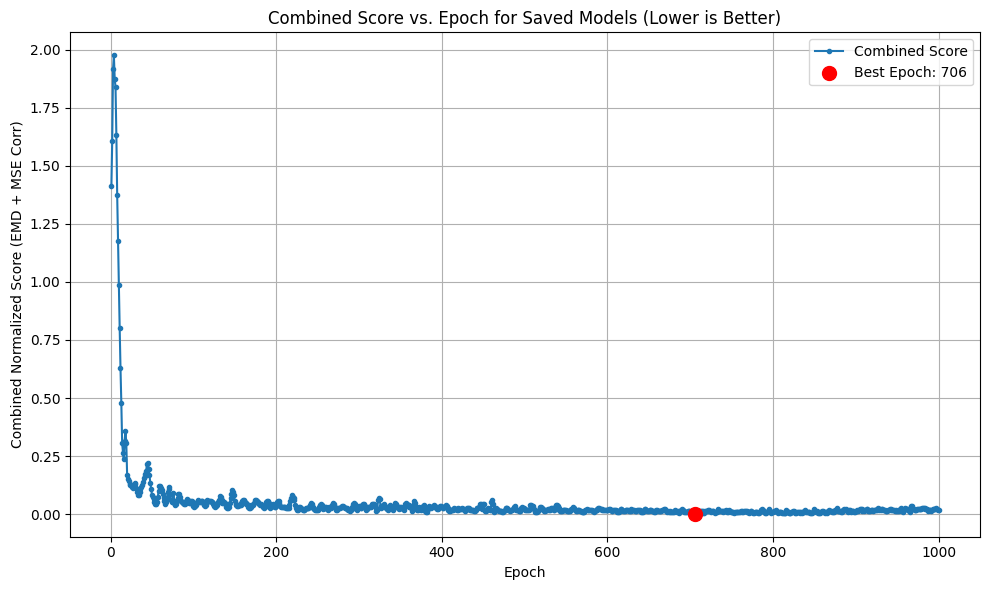

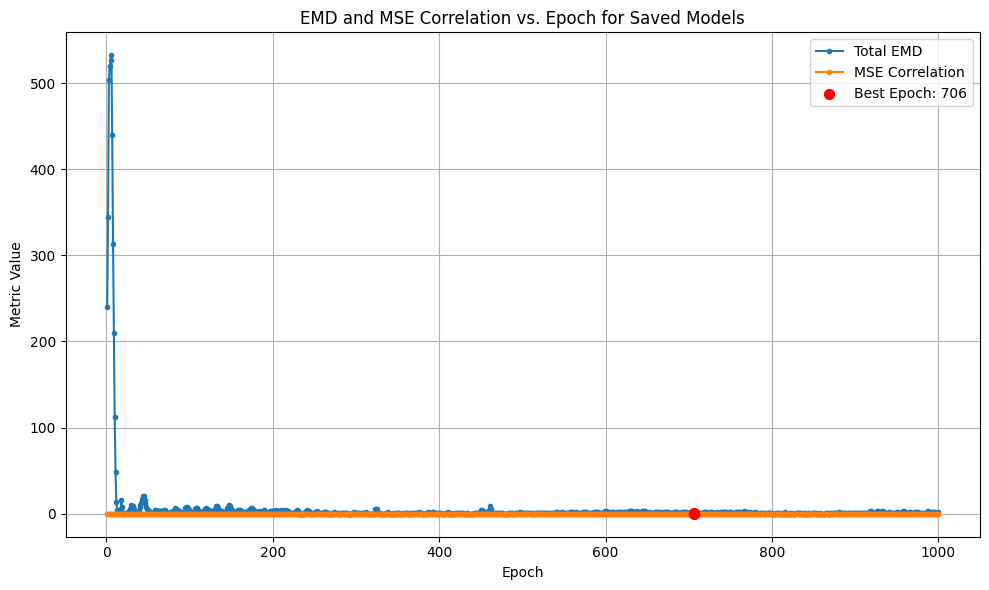

In [5]:



# --- Configuration ---
# df, inv_cdfs, device, latent_dim, Generator, compute_epoch_metrics

print("All required variables found. Proceeding with evaluation.")

# --- Evaluation Loop ---
epoch_metrics = {}
model_files = [f for f in os.listdir(MODELS_DIR) if f.endswith('.pth') and f.startswith('G')]

# Create a fixed noise tensor for consistent evaluation

print(f"Found {len(model_files)} model files in {MODELS_DIR}. Evaluating...")

for i, filename in enumerate(model_files):
    match = re.search(r'G_epoch(\d+)\.pth', filename)
    if match:
        epoch = int(match.group(1))
        print(f"Evaluating model for epoch {epoch}...")
        file_path = os.path.join(MODELS_DIR, filename)

        try:
            # Instantiate a new Generator model for each file
            eval_G = Generator().to(DEVICE)
            eval_G.load_state_dict(torch.load(file_path, map_location=DEVICE))
            eval_G.eval() 

            # Compute metrics using the fixed noise
            mse_corr, total_emd = compute_metrics(eval_G, eval_noise, df, inverse_cdfs)
            

            epoch_metrics[epoch] = {'mse_corr': mse_corr, 'emd': total_emd}
            # print(f"  Epoch {epoch}: MSE_Corr={mse_corr:.6f}, EMD={total_emd:.4f}")
            if (i + 1) % 10 == 0: # Print progress every 10 models
                    print(f"  Processed {i+1}/{len(model_files)} models...")


        except Exception as e:
            print(f"Error processing file {filename}: {e}")
    else:
        print(f"Skipping file with unexpected name format: {filename}")

print(f"Finished evaluating {len(epoch_metrics)} models.")

# --- Find Best Epoch based on Combined Score ---
if epoch_metrics:
    # Sort metrics by epoch for consistent plotting and analysis
    sorted_epochs = sorted(epoch_metrics.keys())
    mse_corr_values = [epoch_metrics[epoch]['mse_corr'] for epoch in sorted_epochs]
    emd_values = [epoch_metrics[epoch]['emd'] for epoch in sorted_epochs]

    # Normalize the metrics 
    emd_np = np.array(emd_values)
    mse_np = np.array(mse_corr_values)

    # Avoid division by zero if all values are the same
    norm_emd = (emd_np - emd_np.min()) / (emd_np.max() - emd_np.min()) if (emd_np.max() - emd_np.min()) > 1e-9 else np.zeros_like(emd_np)
    norm_mse = (mse_np - mse_np.min()) / (mse_np.max() - mse_np.min()) if (mse_np.max() - mse_np.min()) > 1e-9 else np.zeros_like(mse_np)

    # Combine the normalized scores (simple sum, lower is better)
    combined_score = norm_emd + norm_mse

    # Find the index of the minimum combined score
    best_index = np.argmin(combined_score)

    # Get the corresponding epoch number and metrics
    best_epoch = sorted_epochs[best_index]
    best_emd = emd_values[best_index]
    best_mse = mse_corr_values[best_index]
    best_combined_score = combined_score[best_index]

    print("-" * 30)
    print(f"Best epoch based on combined normalized EMD and MSE Correlation: {best_epoch}")
    print(f"  - EMD at epoch {best_epoch}: {best_emd:.4f}")
    print(f"  - MSE Correlation at epoch {best_epoch}: {best_mse:.6f}")
    print(f"  - Combined Normalized Score (lower is better): {best_combined_score:.4f}")
    print("-" * 30)

    #Plot the combined score
    plt.figure(figsize=(10, 6))
    plt.plot(sorted_epochs, combined_score, marker='.', linestyle='-', label='Combined Score')
    plt.scatter(best_epoch, best_combined_score, color='red', s=100, label=f'Best Epoch: {best_epoch}', zorder=5)
    plt.xlabel('Epoch')
    plt.ylabel('Combined Normalized Score (EMD + MSE Corr)')
    plt.title('Combined Score vs. Epoch for Saved Models (Lower is Better)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    #Plot individual metrics
    plt.figure(figsize=(10, 6))
    plt.plot(sorted_epochs, emd_values, marker='.', linestyle='-', label='Total EMD')
    plt.plot(sorted_epochs, mse_corr_values, marker='.', linestyle='-', label='MSE Correlation')
    plt.scatter(best_epoch, best_emd, color='red', s=50, zorder=5)
    plt.scatter(best_epoch, best_mse, color='red', s=50, zorder=5, label=f'Best Epoch: {best_epoch}')
    plt.xlabel('Epoch')
    plt.ylabel('Metric Value')
    plt.title('EMD and MSE Correlation vs. Epoch for Saved Models')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

else:
    print("No valid model metrics were collected. Cannot determine the best epoch.")


### Generating the Final Synthetic Dataset

This block loads the best checkpoint, runs the generator on our fixed noise, and maps the outputs back into the original feature space.


In [ ]:
G_tensor_file_path = f"{MODELS_DIR}/G_epoch{best_epoch}.pth"
# Load the model
Gen = Generator().to(DEVICE) 

#Load the state dictionary
Gen.load_state_dict(torch.load(G_tensor_file_path, map_location=DEVICE))

# Set the model to evaluation mode (important if it uses layers like Dropout or BatchNorm)
Gen.eval()

with torch.no_grad():
    Z_gen = Gen(eval_noise).cpu().numpy()

synthetic_df = pd.DataFrame(invert_samples(Z_gen, inverse_cdfs), columns=df.columns)



### We calculate feature wise earch mover distance between real and synthetic data

In [16]:
mse_corr, total_emd = compute_metrics(eval_G, eval_noise, df, inverse_cdfs)

#print feature wise earch mover distance
for col in df.columns:
    emd = calculate_emd(df[col], synthetic_df[col])
    print(f"EMD for {col}: {emd:.4f}")


EMD for cov1: 0.0003
EMD for cov2: 0.0007
EMD for cov3: 0.0005
EMD for cov4: 0.0004
EMD for cov5: 0.2132
EMD for cov6: 0.0011
EMD for cov7: 0.0009
EMD for sal_pur_rat: 0.6529
EMD for igst_itc_tot_itc_rat: 0.0011
EMD for lib_igst_itc_rat: 0.0146


In [7]:
print("Real data stds:")
print(df.std())
print("\nSynthetic data stds:")
print(synthetic_df.std())

Real data stds:
cov1                    0.135031
cov2                    0.244927
cov3                    0.408193
cov4                    0.388080
cov5                    0.177615
cov6                    0.334306
cov7                    0.385322
sal_pur_rat             1.000000
igst_itc_tot_itc_rat    1.000000
lib_igst_itc_rat        1.000000
dtype: float64

Synthetic data stds:
cov1                    0.108504
cov2                    0.229442
cov3                    0.405456
cov4                    0.388840
cov5                    0.150663
cov6                    0.336417
cov7                    0.370114
sal_pur_rat             1.346155
igst_itc_tot_itc_rat    1.006306
lib_igst_itc_rat        0.985258
dtype: float64


### Correlation Heatmap Comparison

- Compute Pearson correlation matrices for real vs. synthetic data.  
- **Left**: heatmap of `real_corr` with annotations, coolwarm colormap, square cells, and title.  
- **Right**: same for `synthetic_corr`.  

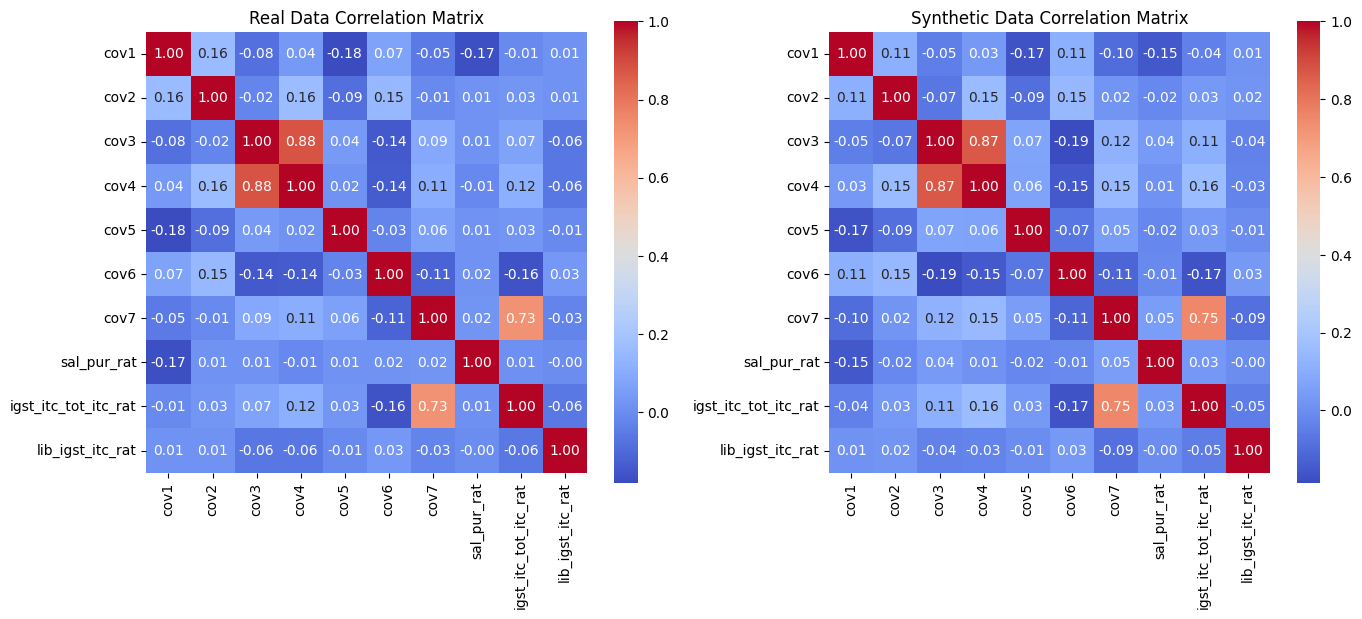

In [8]:
# Compute the pairwise Pearson correlation matrices
real_corr = df.corr(method='pearson')
synthetic_corr = synthetic_df.corr(method='pearson')

# Plot the heatmaps side-by-side for visual comparison
plt.figure(figsize=(14, 6))

# Real data correlation matrix heatmap
plt.subplot(1, 2, 1)
sns.heatmap(real_corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Real Data Correlation Matrix")

# Synthetic data correlation matrix heatmap
plt.subplot(1, 2, 2)
sns.heatmap(synthetic_corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Synthetic Data Correlation Matrix")

plt.tight_layout()
plt.show()


### Absolute Correlation Difference & MSE

- Compute element‑wise difference: `diff_corr = real_corr - synthetic_corr`  
- Take absolute values: `diff_corr_abs = diff_corr.abs()`  
- Print the mean squared difference (MSE) across all correlation entries  


0.000731845321527702


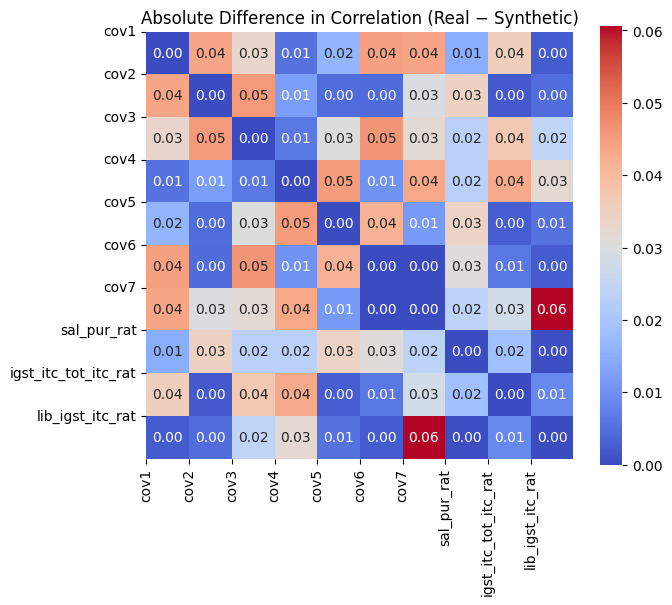

In [9]:
import matplotlib.pyplot as plt
diff_corr = real_corr - synthetic_corr
# Compute the element‑wise difference between the two correlation matrices
# (Assumes `real_corr` and `synthetic_corr` are already in the notebook’s scope)
diff_corr_abs = diff_corr.abs()

# Plot a single heat‑map for the difference matrix
plt.figure(figsize=(7, 6))
sns.heatmap(diff_corr_abs, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Absolute Difference in Correlation (Real − Synthetic)")

# Tick labels
plt.xticks(range(len(diff_corr.columns)), diff_corr.columns, rotation=90)
plt.yticks(range(len(diff_corr.index)), diff_corr.index)
print(((real_corr - synthetic_corr)**2).values.mean())

plt.tight_layout()
plt.show()

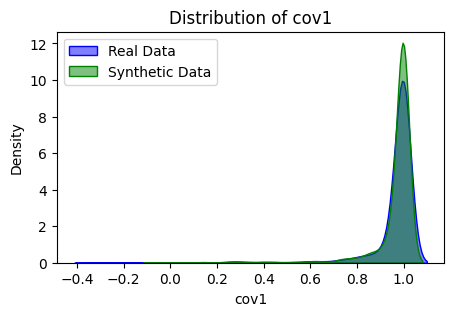

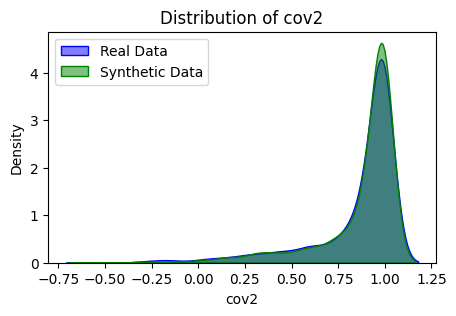

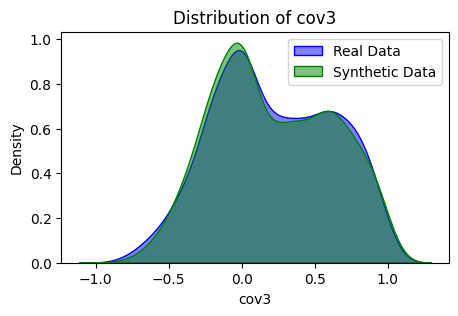

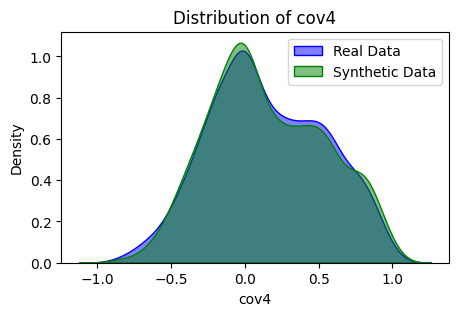

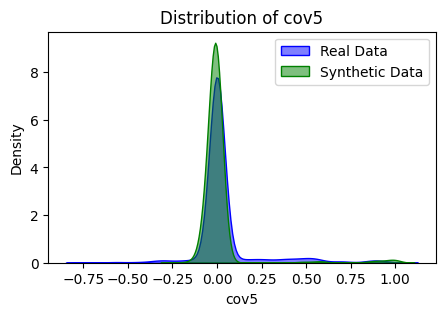

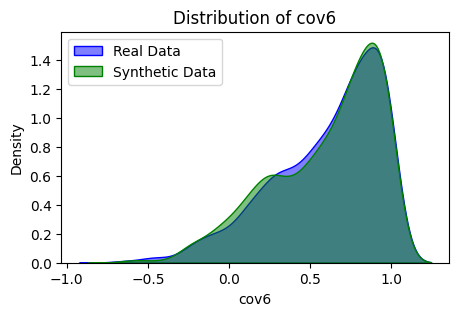

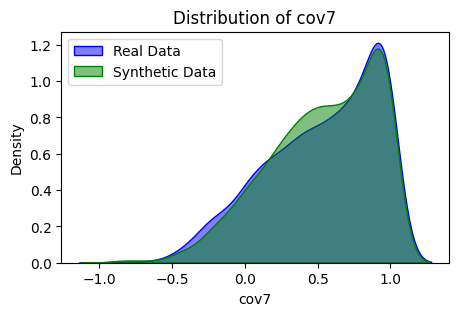

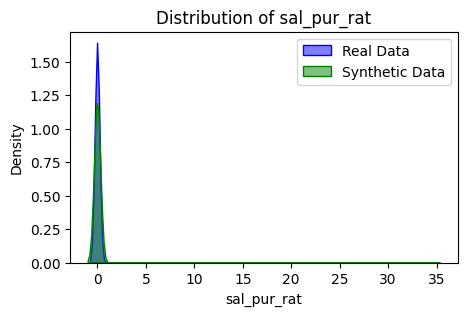

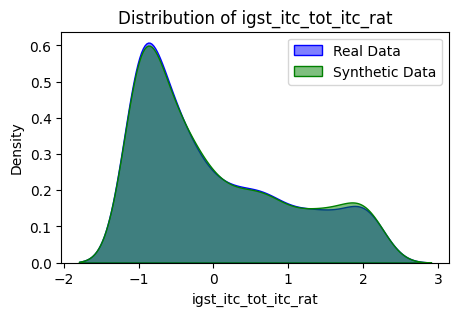

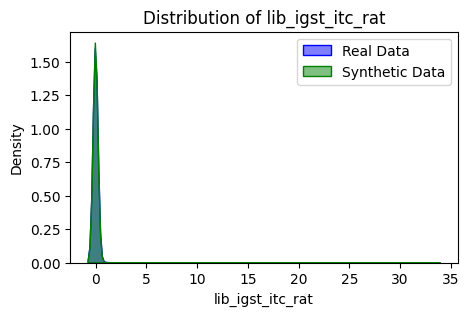

[None, None, None, None, None, None, None, None, None, None]

In [10]:
def plot_numerical_distribution(real_data, synthetic_df, column_name):
    plt.figure(figsize=(5, 3))
    sns.kdeplot(real_data[column_name], label="Real Data", fill=True, color='blue', alpha=0.5)
    sns.kdeplot(synthetic_df[column_name], label="Synthetic Data", fill=True, color='green', alpha=0.5)
    plt.title(f"Distribution of {column_name}")
    plt.xlabel(column_name)
    plt.ylabel("Density")
    plt.legend()
    plt.show()

# List of the 10 feature names from data
columns = [
    'cov1',
    'cov2',
    'cov3',
    'cov4',
    'cov5',
    'cov6',
    'cov7',
    'sal_pur_rat',
    'igst_itc_tot_itc_rat',
    'lib_igst_itc_rat'
]

# Plot distributions for each feature
[plot_numerical_distribution(df, synthetic_df, col) for col in columns]


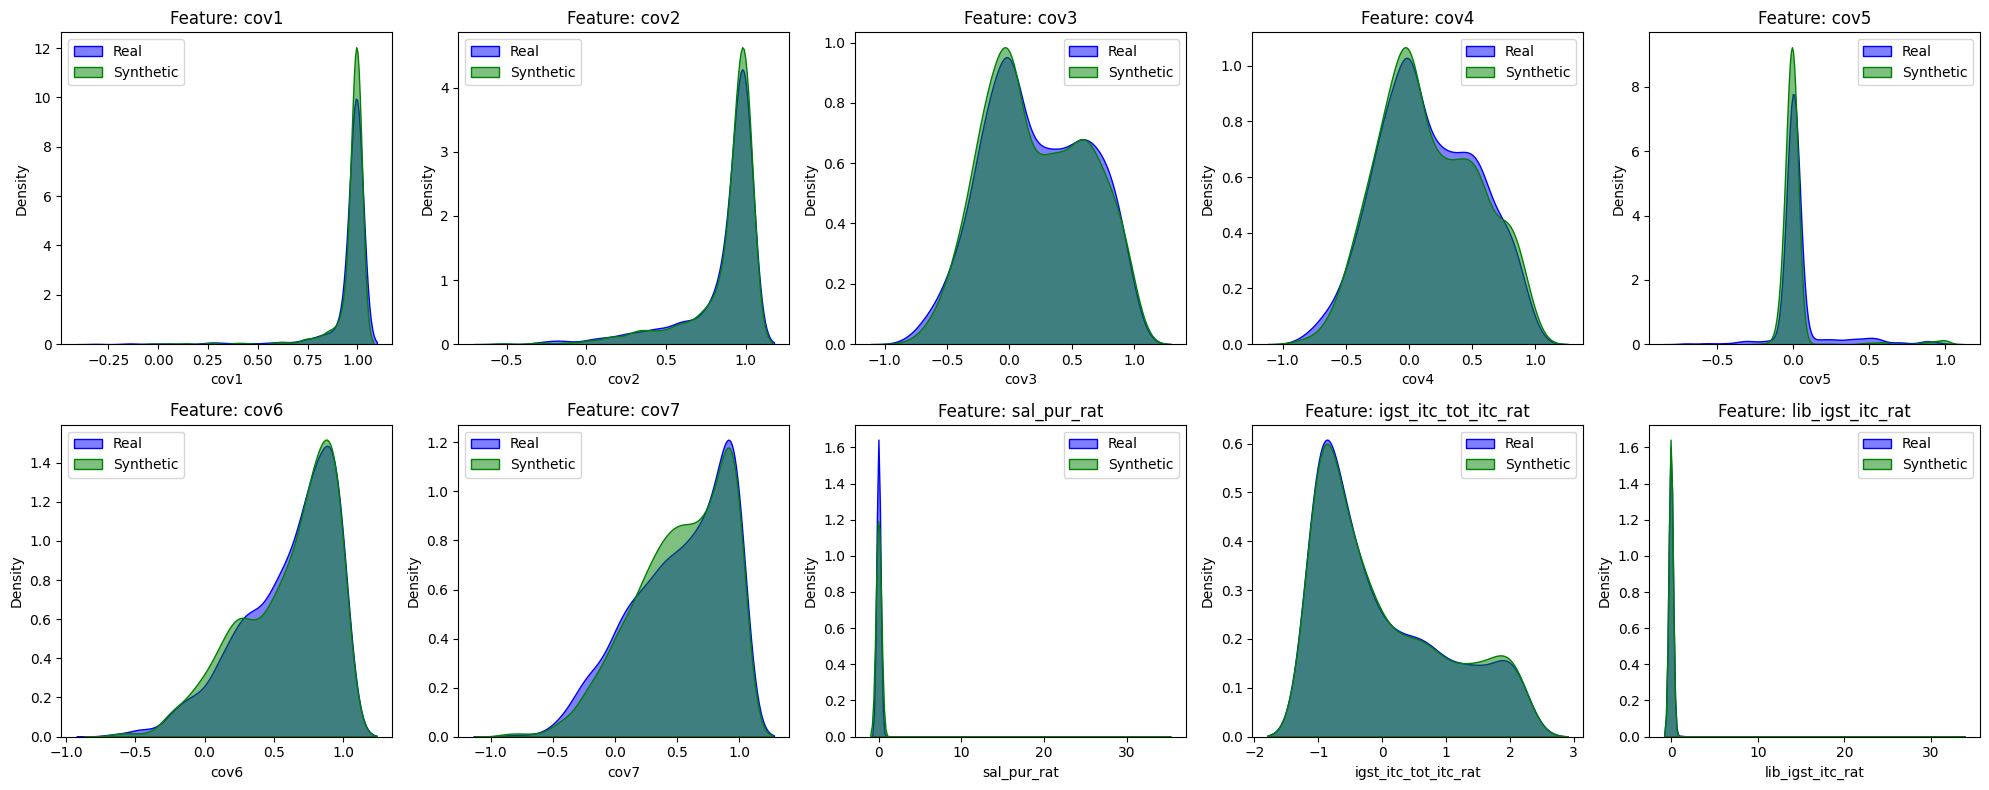

In [11]:
# Plot KDE Distributions for all features

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

plt.figure(figsize=(20, 8))
for i, col in enumerate(num_cols):
    plt.subplot(2, 5, i+1)
    sns.kdeplot(df[col], label="Real", fill=True, color='blue', alpha=0.5)
    sns.kdeplot(synthetic_df[col], label="Synthetic", fill=True, color='green', alpha=0.5)
    plt.title(f"Feature: {col}")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.legend()
plt.tight_layout()
plt.show()



The density value in above plots is beyond 1 which is okay. The area under the curve is integrated to 1. Same issue was encountered here and was addressed according to https://medium.com/analytics-vidhya/what-are-the-odds-kernel-density-estimation-75c9980931e4

"As we can see, the KDE estimates the distribution pretty accurately. Now this estimate is technically not a probability density yet, since its range is much higher than 1. In order to fix this, all we would need to do is normalize it:

points = kde(0.5, dist, gaussian)
points /= np.abs(points).max(axis=0)  # Normalizing"

To get the density in range of 0-1, below are the normalized plots. But these are not representative of the distributions.

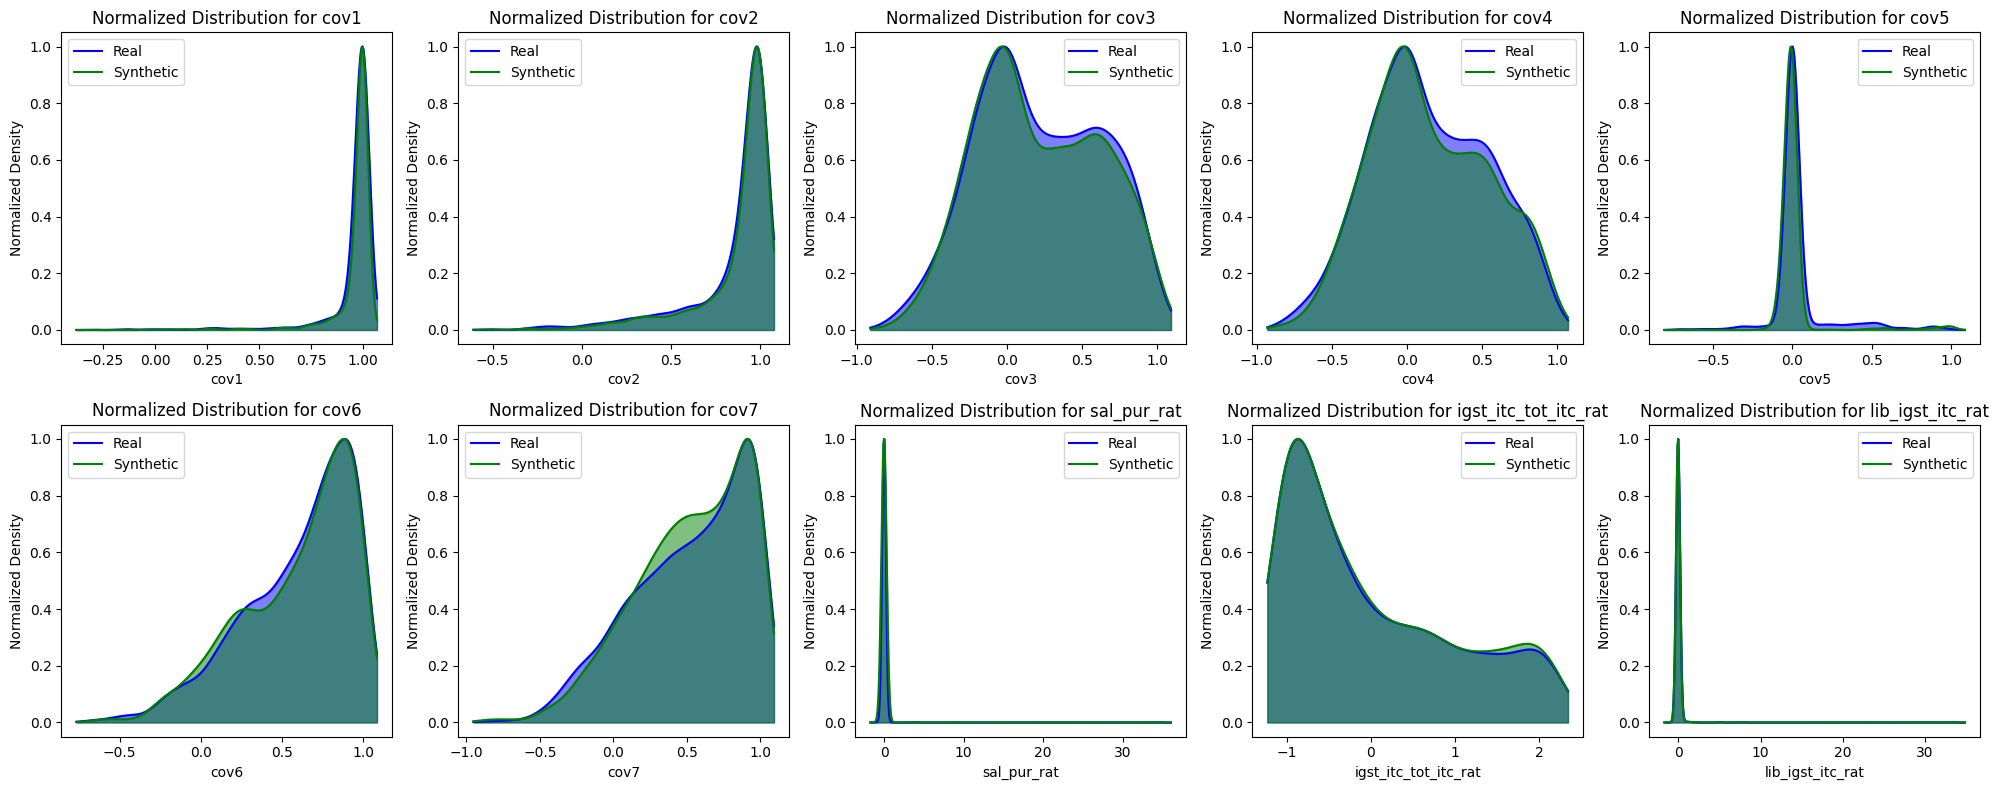

In [12]:
from scipy.stats import gaussian_kde

# Automatically select numerical columns (for our data, these are all 10 features)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

plt.figure(figsize=(20, 8))

for i, col in enumerate(num_cols):
    ax = plt.subplot(2, 5, i+1)
    
    # Get the non-null values for the given column from both real and synthetic data
    real_vals = df[col].dropna().values
    synth_vals = synthetic_df[col].dropna().values
    
    # Define a common x-range that covers both datasets (with a little margin)
    overall_min = min(real_vals.min(), synth_vals.min())
    overall_max = max(real_vals.max(), synth_vals.max())
    margin = 0.05 * (overall_max - overall_min)
    x_range = np.linspace(overall_min - margin, overall_max + margin, 500)
    
    # Compute the KDE for each dataset
    kde_real = gaussian_kde(real_vals)
    kde_synth = gaussian_kde(synth_vals)
    density_real = kde_real(x_range)
    density_synth = kde_synth(x_range)
    
    # Normalize each density by its maximum value
    norm_density_real = density_real / density_real.max()
    norm_density_synth = density_synth / density_synth.max()
    
    # Plot the normalized densities
    ax.plot(x_range, norm_density_real, label="Real", color='blue')
    ax.fill_between(x_range, norm_density_real, color='blue', alpha=0.5)
    ax.plot(x_range, norm_density_synth, label="Synthetic", color='green')
    ax.fill_between(x_range, norm_density_synth, color='green', alpha=0.5)
    
    ax.set_title(f"Normalized Distribution for {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Normalized Density")
    ax.legend()

plt.tight_layout()
plt.show()


Plotting KDE (density) curves for each numerical feature from both the real and synthetic datasets.
- **Plot Details:**
  - **Blue Curve:** Real data distribution.
  - **Green Curve:** Synthetic data distribution.
  - Filled areas enhance visual comparison.

As you can see above the difference in correlation between real and synthetic is very small (range 0.1-0.25, see colorbar).

The real and synthetic data distributions are close.

In [13]:
from scipy.stats import ks_2samp


# Perform the KS Test for each numerical column in the data

# Automatically select numerical columns (for our data, these are all 10 features)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Perform KS Test
ks_results = {}
for col in num_cols:
    stat, p_value = ks_2samp(df[col], synthetic_df[col])
    ks_results[col] = {"KS Statistic": stat, "p-value": p_value}

# Convert the dictionary to a DataFrame and print the results
ks_df = pd.DataFrame.from_dict(ks_results, orient="index")
print("KS Test Results:")
print(ks_df)

KS Test Results:
                      KS Statistic       p-value
cov1                      0.072560  3.615497e-03
cov2                      0.044204  1.919916e-01
cov3                      0.032527  5.501742e-01
cov4                      0.045038  1.756328e-01
cov5                      0.422852  1.748064e-96
cov6                      0.026689  7.868449e-01
cov7                      0.025855  8.179624e-01
sal_pur_rat               0.042535  2.282321e-01
igst_itc_tot_itc_rat      0.013344  9.999279e-01
lib_igst_itc_rat          0.027523  7.543702e-01
